<a href="https://colab.research.google.com/github/rohan1907/StumbleUpon-Evergreen-Classification-Challenge/blob/main/evergreen_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stummble upon evergreen Classification Challenge**



In [1]:
import pandas as pd 
import numpy as np 
import tensorflow_hub as hub
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline 
import tensorflow as tf 

In [2]:
# taking all columns of training set only for data exploration
df_train=pd.read_csv('/content/data/train.tsv',sep='\t')
# taking boilerplate column as an input for the model beacuse only this column contain lot of high quality text data
df_test=pd.read_csv('/content/data/test.tsv',sep='\t', usecols=['urlid','boilerplate'])


In [3]:
df_train.head()

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1,1,24,0,5424,170,8,0.152941,0.079130,0
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,0,0.098707,0,0.203490,0.088652,1,1,40,0,4973,187,9,0.181818,0.125448,1
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,0,0.072448,0,0.226402,0.120536,1,1,55,0,2240,258,11,0.166667,0.057613,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,0.0,0,0.095861,0,0.265656,0.035343,1,0,24,0,2737,120,5,0.041667,0.100858,1
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,0.0,0,0.024908,0,0.228887,0.050473,1,1,14,0,12032,162,10,0.098765,0.082569,0


In [4]:
#cleaning the train dataframe

df_train['boilerplate'].replace(to_replace=r'"title":', value="",inplace=True,regex=True)
df_train['boilerplate'].replace(to_replace=r'"url":',value="",inplace=True,regex=True)

df_train['boilerplate'].replace(to_replace=r'{|}',value="",inplace=True,regex=True)
df_train['boilerplate']=df_train['boilerplate'].str.lower()

#Cleaning the test dataframe 

df_test['boilerplate'].replace(to_replace=r'"title":', value="",inplace=True,regex=True)
df_test['boilerplate'].replace(to_replace=r'"url":',value="",inplace=True,regex=True)

df_test['boilerplate'].replace(to_replace=r'{|}',value="",inplace=True,regex=True)
df_test['boilerplate']=df_test['boilerplate'].str.lower()

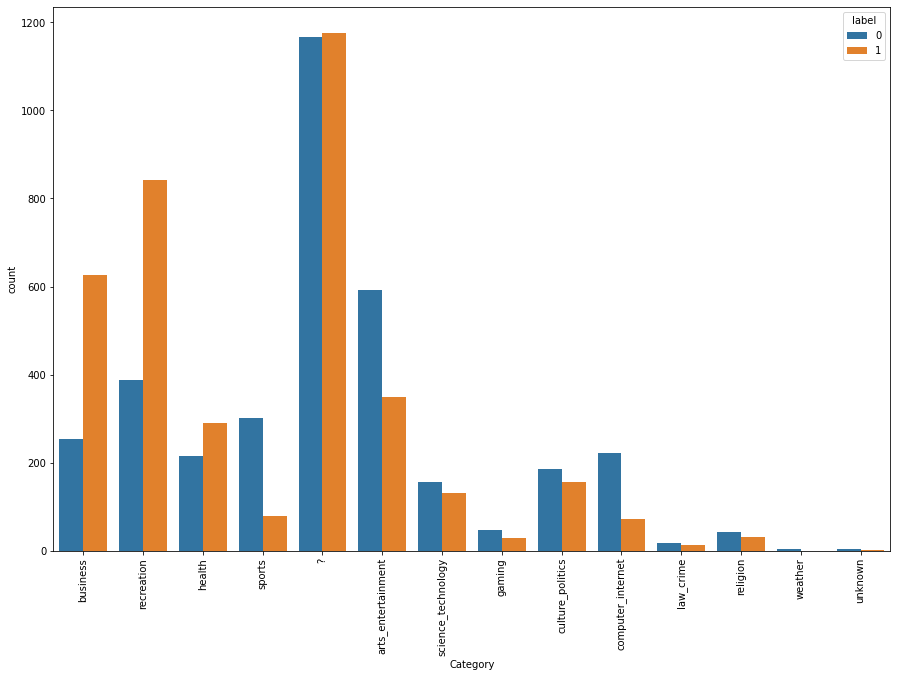

In [5]:
plt.figure(figsize=(15,10))
sns.countplot(x=df_train['alchemy_category'],hue=df_train['label']);
plt.xlabel('Category');
plt.xticks(rotation=90);

In [6]:
text_train = df_train.boilerplate #extracting the train text from the bolierplate column
text_test = df_test.boilerplate #extracting the test text from the boilerplate column
urlid_test = df_test.urlid #extracting urlid from test dataset
y_train = df_train.label.values #extracting prediction labels 

In [7]:
#splitting the train data into train and validation dataset
x_val = text_train[:3000]
partial_x_train = text_train[3000:]

y_val = y_train[:3000]
partial_y_train = y_train[3000:]
text_train[:3]

0    "ibm sees holographic calls air breathing batt...
1    "the fully electronic futuristic starting gun ...
2    "fruits that fight the flu fruits that fight t...
Name: boilerplate, dtype: object

In [8]:
#downloading the word embedding model from tensorflow hub. 
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)

In [9]:
#creating the model 

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
dense (Dense)                (None, 128)               6528      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 48,205,649
Trainable params: 48,205,549
Non-trainable params: 100
__________________________________________

In [10]:
#model compilation with adam optimizer 
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer='adam',metrics=[tf.keras.metrics.AUC()])

In [11]:
#training the model, epochs = 40
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
9/9 [==============================] - 2s 148ms/step - loss: 0.6408 - auc: 0.6776 - val_loss: 0.6035 - val_auc: 0.8206
Epoch 2/40
9/9 [==============================] - 1s 91ms/step - loss: 0.5070 - auc: 0.8339 - val_loss: 0.5449 - val_auc: 0.8480
Epoch 3/40
9/9 [==============================] - 1s 102ms/step - loss: 0.4637 - auc: 0.8695 - val_loss: 0.5257 - val_auc: 0.8555
Epoch 4/40
9/9 [==============================] - 1s 93ms/step - loss: 0.4241 - auc: 0.8952 - val_loss: 0.5116 - val_auc: 0.8609
Epoch 5/40
9/9 [==============================] - 1s 92ms/step - loss: 0.3893 - auc: 0.9092 - val_loss: 0.5073 - val_auc: 0.8638
Epoch 6/40
9/9 [==============================] - 1s 93ms/step - loss: 0.3610 - auc: 0.9231 - val_loss: 0.4926 - val_auc: 0.8659
Epoch 7/40
9/9 [==============================] - 1s 92ms/step - loss: 0.3124 - auc: 0.9434 - val_loss: 0.4811 - val_auc: 0.8654
Epoch 8/40
9/9 [==============================] - 1s 92ms/step - loss: 0.2809 - auc: 0.9537 - v

In [12]:
predictions=model.predict(text_test) #model prediction

In [13]:
val=[1 if i>=0.5 else 0 for i in predictions]

In [14]:
df_test['label']=val

df_test.to_csv('submissions.csv',columns=['urlid','label'],index=False) #saving submission file

In [15]:
history_dict = history.history
key=history_dict.keys()
key

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])

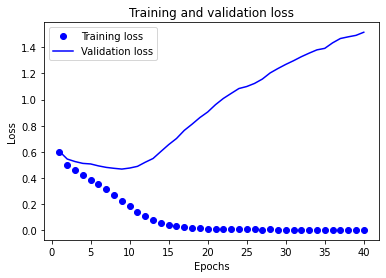

In [17]:
acc = history_dict['auc']
val_acc = history_dict['val_auc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

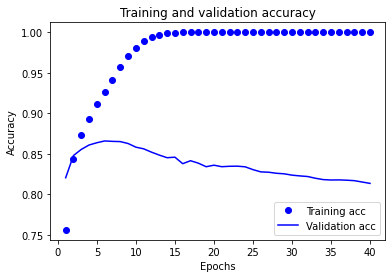

In [18]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()